# Analysing Children Data

### Loading libraries

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from scipy.stats import ttest_ind
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import PCA
import statsmodels.formula.api as smf
from scipy.stats import f_oneway
from statsmodels.formula.api import ols
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor
from datetime import timedelta

### Loading the datasets

In [2]:
children = pd.read_csv("data_children.csv")
df_weighted = pd.read_csv("weight_subscores.csv")

Session 1 scores will be taken as the baseline scores. First, we wish to check the relationship of the baseline scores with the hair and saliva cortisol levels. Second, we would be checking the predictive relationship of baseline subluxation levels and the hair and saliva cortisol levels. We will assume baseline subluxation as the independent variable, and the hair and saliva cortisol levels as the dependent variables.

we will also extract the subluxation scores for each patient's last session and will create a new column with these values. These will act as the subluxation scores after the 12 week intervention.

In [3]:
# Step 1: Select only columns containing "Weighted Sum"
weighted_sum_cols = [col for col in df_weighted.columns if "Weighted Sum" in col]

# Step 2: Get the last non-zero value in each row from selected columns
df_weighted['Last Intervention Score'] = df_weighted[weighted_sum_cols].apply(
    lambda row: row[row != 0].dropna().iloc[-1] if (row[row != 0].dropna().size > 0) else None, axis=1
)

# Step 3: Extract session time columns (excluding Weighted Sum ones)
time_cols = [col for col in df_weighted.columns if col.startswith('Session') and 'Weighted Sum' not in col]

# Step 4: Convert session time strings to datetime (ISO format like '2022-04-22 13:50:00')
df_time = df_weighted[time_cols].apply(pd.to_datetime, errors='coerce')

# Step 5: Get the first session date per row
first_session = df_time.min(axis=1)

# Step 6: Initialize the new column
df_weighted['Mid Intervention Score'] = None

# Step 7: Loop to extract the score 42 days after the first session
for idx in df_weighted.index:
    base_date = first_session.loc[idx]
    if pd.isnull(base_date):
        continue

    # Target is 42 days after base
    target_date = base_date + timedelta(days=42)

    # Get session columns on or after this date
    session_times = df_time.loc[idx]
    future_sessions = session_times[session_times >= target_date].sort_values()

    if not future_sessions.empty:
        session_col = future_sessions.index[0]  # Get first session after 42 days
        weighted_sum_col = session_col + ' Weighted Sum'

        if weighted_sum_col in df_weighted.columns:
            df_weighted.at[idx, 'Mid Intervention Score'] = df_weighted.at[idx, weighted_sum_col]

# Resulting DataFrame
df_weighted

,ID,Enrolment Date,Initial Care Plan,Age Group,Active/Passive,Session 1,Session 1 Weighted Sum,Session 2,Session 2 Weighted Sum,Session 3,...,Session 33,Session 33 Weighted Sum,Session 34,Session 34 Weighted Sum,Session 35,Session 35 Weighted Sum,Session 36,Session 36 Weighted Sum,Last Intervention Score,Mid Intervention Score
0,1,20/4,3x4,Adults,Active,2022-04-20 14:00:00,26,2022-04-22 13:50:00,22,2022-04-25 14:45:00,...,NaT,0,NaT,0,NaT,0,NaT,0,10,21
1,2,20/4,3x4,Adults,Active,2022-04-20 12:35:00,19,2022-04-22 08:50:00,25,2022-04-23 09:20:00,...,NaT,0,NaT,0,NaT,0,NaT,0,16,16
2,4,19/4,3x4,Adults,Active,2022-04-19 12:55:00,17,2022-04-20 11:50:00,19,2022-04-23 10:06:00,...,NaT,0,NaT,0,NaT,0,NaT,0,12,20
3,5,21/4,3x4,Adults,Active,2022-04-21 12:35:00,25,2022-04-22 12:55:00,24,2022-04-25 14:20:00,...,NaT,0,NaT,0,NaT,0,NaT,0,12,9
4,6,20/4,3x4,Adults,Active,2022-04-20 13:40:00,24,2022-04-22 12:45:00,22,2022-04-25 15:00:00,...,NaT,0,NaT,0,NaT,0,NaT,0,17,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,243,NaN,NaN,Children,Passive,2022-06-06 10:48:00,21,2022-06-21 12:17:00,12,2022-07-27 12:17:00,...,NaT,0,NaT,0,NaT,0,NaT,0,12,12
199,247,2022-07-06 00:00:00,NaN,Children,Passive,2022-06-07 17:48:00,25,NaT,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,18,19
200,248,2022-07-06 00:00:00,NaN,Children,Passive,2022-06-07 17:53:00,27,NaT,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,18,29
201,249,2022-07-06 00:00:00,NaN,Children,Passive,2022-06-07 17:56:00,18,NaT,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,20,28


We will do the above for the chikdren data as well to assess the results separately later.

In [4]:
# Step 1: Select only columns containing "Weighted Sum"
weighted_sum_cols = [col for col in children.columns if "Weighted Sum" in col]

# Step 2: Get the last non-zero value in each row from selected columns
children['Last Intervention Score'] = children[weighted_sum_cols].apply(
    lambda row: row[row != 0].dropna().iloc[-1] if (row[row != 0].dropna().size > 0) else None, axis=1
)

# Step 3: Extract session time columns (excluding Weighted Sum ones)
time_cols = [col for col in children.columns if col.startswith('Session') and 'Weighted Sum' not in col]

# Step 4: Convert session time strings to datetime (ISO format like '2022-04-22 13:50:00')
df_time = children[time_cols].apply(pd.to_datetime, errors='coerce')

# Step 5: Get the first session date per row
first_session = df_time.min(axis=1)

# Step 6: Initialize the new column
children['Mid Intervention Score'] = None

# Step 7: Loop to extract the score 42 days after the first session
for idx in children.index:
    base_date = first_session.loc[idx]
    if pd.isnull(base_date):
        continue

    # Target is 42 days after base
    target_date = base_date + timedelta(days=42)

    # Get session columns on or after this date
    session_times = df_time.loc[idx]
    future_sessions = session_times[session_times >= target_date].sort_values()

    if not future_sessions.empty:
        session_col = future_sessions.index[0]  # Get first session after 42 days
        weighted_sum_col = session_col + ' Weighted Sum'

        if weighted_sum_col in df_weighted.columns:
            children.at[idx, 'Mid Intervention Score'] = children.at[idx, weighted_sum_col]

# Resulting DataFrame
children

,Unnamed: 0,ID,Enrolment Date,Initial Care Plan,Age Group,Active/Passive,Session 1,Session 1 Weighted Sum,Session 1 Cervical,Session 1 Lumbar,...,Session 36 Thoracic,Group,Gender,Hair Cortisol Baseline,Hair Cortisol FollowUp,Saliva Cortisol Baseline,Saliva Cortisol Intervention,Saliva Cortisol FollowUp,Last Intervention Score,Mid Intervention Score
0,57,136,NaN,NaN,Children,Active,NaT,0,0,0,...,0,1,1,20,20.0,1.690,34.434,8.235,11,23
1,58,139,NaN,NaN,Children,Active,2022-05-31 16:33:00,23,15,0,...,0,1,1,132,163.0,1.570,11.840,10.238,10,23
2,59,141,NaN,NaN,Children,Active,2022-05-31 16:38:00,26,18,0,...,0,1,1,20,43.0,5.231,11.235,9.573,11,26
3,60,142,30/5,3X4,Children,Active,2022-05-30 17:04:00,24,15,3,...,0,1,1,20,76.0,1.500,25.842,11.795,10,24
4,61,144,30/5,3X4,Children,Active,2022-05-30 16:10:00,26,18,3,...,0,1,1,56,218.0,4.235,30.772,18.523,10,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,198,243,NaN,NaN,Children,Passive,2022-06-06 10:48:00,21,13,0,...,0,2,2,114,32.0,7.235,14.235,15.421,12,21
76,199,247,2022-07-06 00:00:00,NaN,Children,Passive,2022-06-07 17:48:00,25,13,0,...,0,2,1,119,20.0,6.214,11.179,15.236,18,25
77,200,248,2022-07-06 00:00:00,NaN,Children,Passive,2022-06-07 17:53:00,27,15,0,...,0,2,1,35,20.0,12.240,13.238,NaN,18,27
78,201,249,2022-07-06 00:00:00,NaN,Children,Passive,2022-06-07 17:56:00,18,10,2,...,0,2,1,155,109.0,15.846,12.253,28.046,20,18


### Correlation between the variables

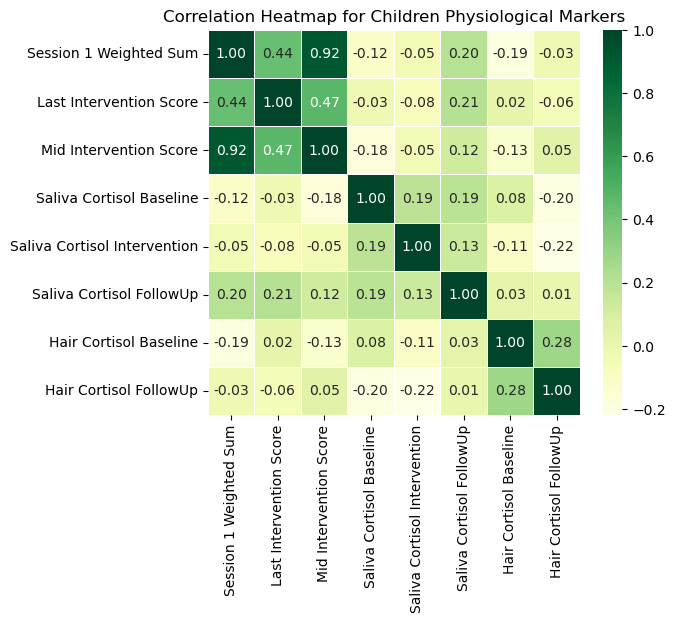

In [5]:
# Select specific columns
columns_to_plot = ["Session 1 Weighted Sum", "Last Intervention Score", "Mid Intervention Score", 
                   "Saliva Cortisol Baseline", "Saliva Cortisol Intervention", "Saliva Cortisol FollowUp", 
                   "Hair Cortisol Baseline", "Hair Cortisol FollowUp"]  
corr_matrix = children[columns_to_plot].corr(method="spearman")

# Create a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap="YlGn", fmt=".2f", linewidths=0.5)

# Add title
plt.title("Correlation Heatmap for Children Physiological Markers")
plt.show()

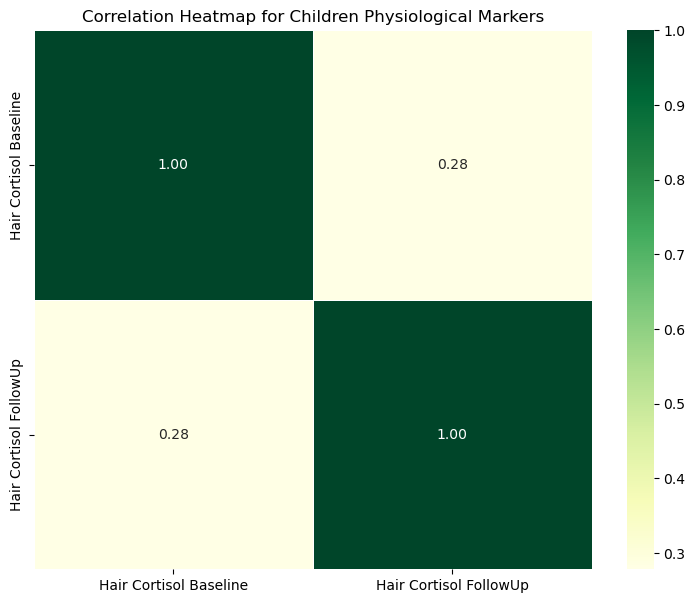

In [6]:
# Select specific columns
columns_to_plot = ["Hair Cortisol Baseline", "Hair Cortisol FollowUp"]  
corr_matrix = children[columns_to_plot].corr(method="spearman")

# Create a heatmap
plt.figure(figsize=(9, 7))
sns.heatmap(corr_matrix, annot=True, cmap="YlGn", fmt=".2f", linewidths=0.5)

# Add title
plt.title("Correlation Heatmap for Children Physiological Markers")
plt.show()

The correlation plot suggests that there is no strong correlation between any of the variables, but Mid Intervention Scores and Last Intervention Scores seem to be correlated positively. 

## Linear Models

### Assessing the relationship between Baseline Subluxation, Mid-point Subluxation, and Subluxation after Intervention

# Predicting Saliva Cortisol 

## SVR

# Active

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'C': 10, 'epsilon': 0.5, 'gamma': 1}
Cross-validated R²: Mean=-0.22, Std=0.22
Cross-validated RMSE: 8.16
Test Set R²: -0.61
Test Set RMSE: 11.62


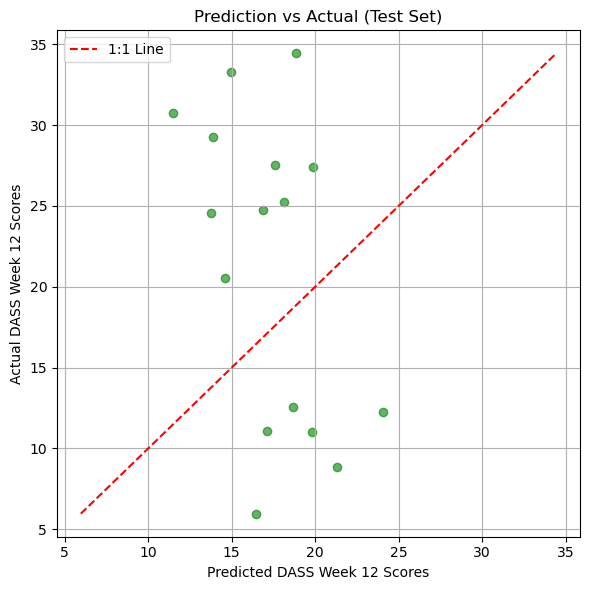

In [11]:
# ---------------------------
# 1. Fill missing values and encode
# ---------------------------
children_filled = children.fillna(0)

# Step 2: Encode Active/Passive
children_filled['Active_Passive_Encoded'] = children_filled['Active/Passive'].map({'Passive': 0, 'Active': 1})
children_filled['Active_Passive_Encoded'] = children_filled['Active_Passive_Encoded'].fillna(0)




# ---------------------------
# 2. Train/test split
# ---------------------------
train, test = train_test_split(children_filled, test_size=0.2, random_state=42)
train = train.sort_values('Last Intervention Score')
test = test.sort_values('Last Intervention Score')

# ---------------------------
# 3. Select features/target
# ---------------------------
features = ['Last Intervention Score', 'Hair Cortisol Baseline', 'Mid Intervention Score', 'Saliva Cortisol Baseline', 'Active_Passive_Encoded']
X_train = train[features]
X_test = test[features]
y_train = train['Saliva Cortisol Intervention']
y_test = test['Saliva Cortisol Intervention']

# ---------------------------
# 4. Standardize features
# ---------------------------
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---------------------------
# 5. Hyperparameter tuning (RBF SVR)
# ---------------------------
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.1, 1],
    'epsilon': [0.01, 0.1, 0.5]
}

svr = SVR(kernel='rbf')
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

best_svr = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# ---------------------------
# 6. Cross-validation on train set
# ---------------------------
cv_scores = cross_val_score(best_svr, X_train_scaled, y_train, cv=5, scoring='r2')
cv_predictions = cross_val_predict(best_svr, X_train_scaled, y_train, cv=5)
cv_rmse = round(np.sqrt(metrics.mean_squared_error(y_train, cv_predictions)), 2)

print(f"Cross-validated R²: Mean={cv_scores.mean():.2f}, Std={cv_scores.std():.2f}")
print(f"Cross-validated RMSE: {cv_rmse}")

# ---------------------------
# 7. Fit best model to train and evaluate on test set
# ---------------------------
best_svr.fit(X_train_scaled, y_train)
y_test_pred = best_svr.predict(X_test_scaled)
test_r2 = round(metrics.r2_score(y_test, y_test_pred), 2)
test_rmse = round(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), 2)

print(f"Test Set R²: {test_r2}")
print(f"Test Set RMSE: {test_rmse}")

# ---------------------------
# 8. Plot Predictions vs Actual (Test Set)
# ---------------------------
plt.figure(figsize=(6,6))
plt.scatter(y_test_pred, y_test, alpha=0.6, color='green')
min_val = min(y_test_pred.min(), y_test.min())
max_val = max(y_test_pred.max(), y_test.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='1:1 Line')
plt.xlabel('Predicted DASS Week 12 Scores')
plt.ylabel('Actual DASS Week 12 Scores')
plt.title('Prediction vs Actual (Test Set)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
y_train_pred = best_svr.predict(X_train_scaled)
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(train_rmse)
print(train_r2)

5.031306065547194
0.5466558769019771


## Random Forest

# Active

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Tuned Random Forest CV R²: Mean=-0.11, Std=0.11
Tuned Random Forest CV RMSE: 7.67
Tuned Random Forest Test Set R²: -0.32
Tuned Random Forest Test Set RMSE: 10.51


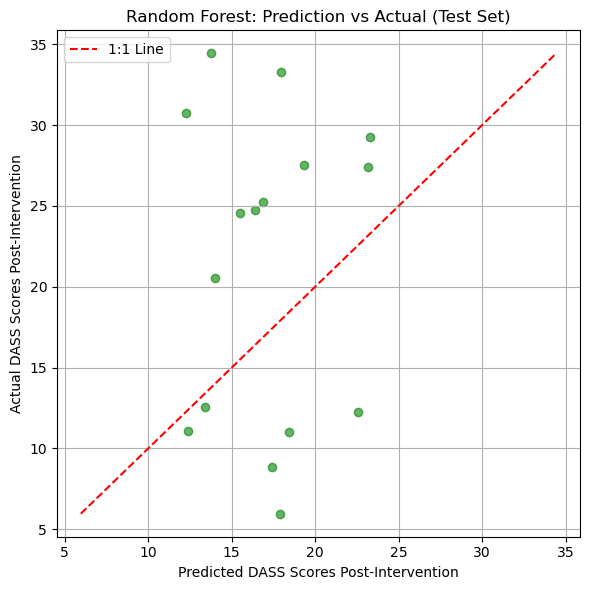

In [13]:
# ---------------------------
# 1. Define features and target
# ---------------------------
X = children_filled[['Last Intervention Score', 'Hair Cortisol Baseline', 'Mid Intervention Score', 'Saliva Cortisol Baseline', 'Active_Passive_Encoded']]
y = children_filled['Saliva Cortisol Intervention']

# ---------------------------
# 2. Train/test split (for later evaluation only)
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------------------------
# 3. Define hyperparameter grid
# ---------------------------
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2]
}

# ---------------------------
# 4. Grid Search CV
# ---------------------------
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# ---------------------------
# 5. Cross-validation on full training set
# ---------------------------
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='r2')
cv_predictions = cross_val_predict(best_rf, X_train, y_train, cv=5)
cv_rmse = round(np.sqrt(metrics.mean_squared_error(y_train, cv_predictions)), 2)

print(f"Tuned Random Forest CV R²: Mean={cv_scores.mean():.2f}, Std={cv_scores.std():.2f}")
print(f"Tuned Random Forest CV RMSE: {cv_rmse}")

# ---------------------------
# 6. Fit best model and test set evaluation
# ---------------------------
best_rf.fit(X_train, y_train)
y_test_pred = best_rf.predict(X_test)

test_r2 = round(metrics.r2_score(y_test, y_test_pred), 2)
test_rmse = round(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), 2)

print(f"Tuned Random Forest Test Set R²: {test_r2}")
print(f"Tuned Random Forest Test Set RMSE: {test_rmse}")

# ---------------------------
# 7. Plot Predictions vs Actual on Test Set
# ---------------------------
plt.figure(figsize=(6, 6))
plt.scatter(y_test_pred, y_test, alpha=0.6, color='green')
min_val = min(min(y_test_pred), min(y_test))
max_val = max(max(y_test_pred), max(y_test))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='1:1 Line')
plt.xlabel("Predicted DASS Scores Post-Intervention")
plt.ylabel("Actual DASS Scores Post-Intervention")
plt.title("Random Forest: Prediction vs Actual (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
y_train_pred_rf = best_rf.predict(X_train)
train_r2_rf = round(metrics.r2_score(y_train, y_train_pred_rf), 2)
train_rmse_rf = round(np.sqrt(metrics.mean_squared_error(y_train, y_train_pred_rf)), 2)

print(f"Random Forest - Training R²: {train_r2_rf}, RMSE: {train_rmse_rf}")


Random Forest - Training R²: 0.53, RMSE: 5.11


# GBR

# Active

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Tuned Gradient Boosting CV R²: Mean=-0.02, Std=0.05
Tuned Gradient Boosting CV RMSE: 7.44
Tuned Gradient Boosting Test Set R²: -0.24
Tuned Gradient Boosting Test Set RMSE: 10.22


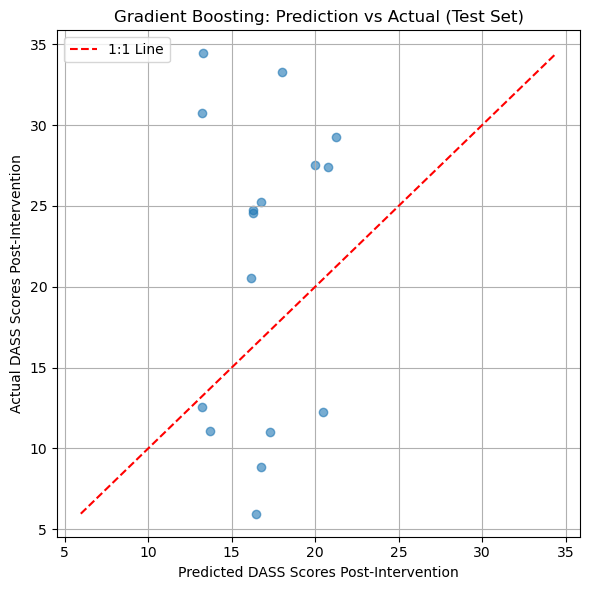

In [15]:
# ---------------------------
# 1. Define features and target
# ---------------------------
X = children_filled[['Last Intervention Score', 'Hair Cortisol Baseline', 'Mid Intervention Score',  'Saliva Cortisol Baseline', 'Active_Passive_Encoded']]
y = children_filled['Saliva Cortisol Intervention']

# ---------------------------
# 2. Train/test split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------------------------
# 3. Define hyperparameter grid
# ---------------------------
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# ---------------------------
# 4. Grid Search CV
# ---------------------------
gb = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(gb, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_gb = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# ---------------------------
# 5. Cross-validation on full training set
# ---------------------------
cv_scores = cross_val_score(best_gb, X_train, y_train, cv=5, scoring='r2')
cv_predictions = cross_val_predict(best_gb, X_train, y_train, cv=5)
cv_rmse = round(np.sqrt(metrics.mean_squared_error(y_train, cv_predictions)), 2)

print(f"Tuned Gradient Boosting CV R²: Mean={cv_scores.mean():.2f}, Std={cv_scores.std():.2f}")
print(f"Tuned Gradient Boosting CV RMSE: {cv_rmse}")

# ---------------------------
# 6. Fit best model and test set evaluation
# ---------------------------
best_gb.fit(X_train, y_train)
y_test_pred = best_gb.predict(X_test)

test_r2 = round(metrics.r2_score(y_test, y_test_pred), 2)
test_rmse = round(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), 2)

print(f"Tuned Gradient Boosting Test Set R²: {test_r2}")
print(f"Tuned Gradient Boosting Test Set RMSE: {test_rmse}")

# ---------------------------
# 7. Plot Predictions vs Actual on Test Set
# ---------------------------
plt.figure(figsize=(6, 6))
plt.scatter(y_test_pred, y_test, alpha=0.6)
min_val = min(min(y_test_pred), min(y_test))
max_val = max(max(y_test_pred), max(y_test))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='1:1 Line')
plt.xlabel("Predicted DASS Scores Post-Intervention")
plt.ylabel("Actual DASS Scores Post-Intervention")
plt.title("Gradient Boosting: Prediction vs Actual (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
y_train_pred_gb = best_gb.predict(X_train)
train_r2_gb = round(metrics.r2_score(y_train, y_train_pred_gb), 2)
train_rmse_gb = round(np.sqrt(metrics.mean_squared_error(y_train, y_train_pred_gb)), 2)

print(f"Gradient Boosting - Training R²: {train_r2_gb}, RMSE: {train_rmse_gb}")


Gradient Boosting - Training R²: 0.42, RMSE: 5.69
